# When to Trust Your Model: Model-Based Policy Optimization

[基于模型的强化学习算法，基本原理以及前沿进展](https://zhuanlan.zhihu.com/p/162787188)

## Monotonic improvement with model bias

基于模型的方法往往是在环境模型中提升策略的性能，但这并不能保证在真实环境中策略性能也有所提升。因此，我们希望模型环境和真实环境中的结果的差距有一定的限制，具体可形式化为：
$$
\eta[\pi] \geq \hat{\eta}[\pi]-C
$$

其中, $\eta[\pi]$ 是 $\pi$ 在 true MDP 中的期望回报, 而$\hat{\eta}[\pi]$ 是 $\pi$ 在模型中的期望回报. 这个公式表明了: 只要在模型中至少改进了C, 我们就可以保证在true MDP中策略得到了改善. (Such a statement guarantees that, as long as we improve by at least C under the
model, we can guarantee improvement on the true MDP.)

> 也就是说, true MDP 和模型的差距有一个上界, 我们只要使模型性能的提高超过了这个上界, 那么即使模型和真实环境有误差,也可以保证在true MDP中的策略得到了改进.

真实回报和模型回报之间的差距(推演误差),C,可以用模型的两个误差量来表示：
1. 由于采样引起的**泛化误差**.
2. 由于更新后的策略遭遇了模型训练时没见过的状态引起的**分布偏移**.

> 不同的策略对应不同的状态分布(?)

在本文中, **泛化误差**用$\epsilon_{m}=\max _{t} E_{s \sim \pi_{D, t}}\left[D_{T V}\left(p\left(s^{\prime}, r \mid s, a\right) \| p_{\theta}\left(s^{\prime}, r \mid s, a\right)\right)\right]$表示, 在实践中, 可以通过测量模型的数据收集策略$\pi_D$的随时间变化的状态分布的验证损失来进行估算. (which can be estimated in practice by measuring the validation loss of the model on the time-dependent state distribution of the data-collecting policy $\pi_D$).

**分布偏移**用迭代间策略的最大总变差距离$\max _{S} D_{T V}\left(\pi \| \pi_{D}\right) \leq \epsilon_{\pi}$表示, (实践上使用KL散度).

故新的bound为:

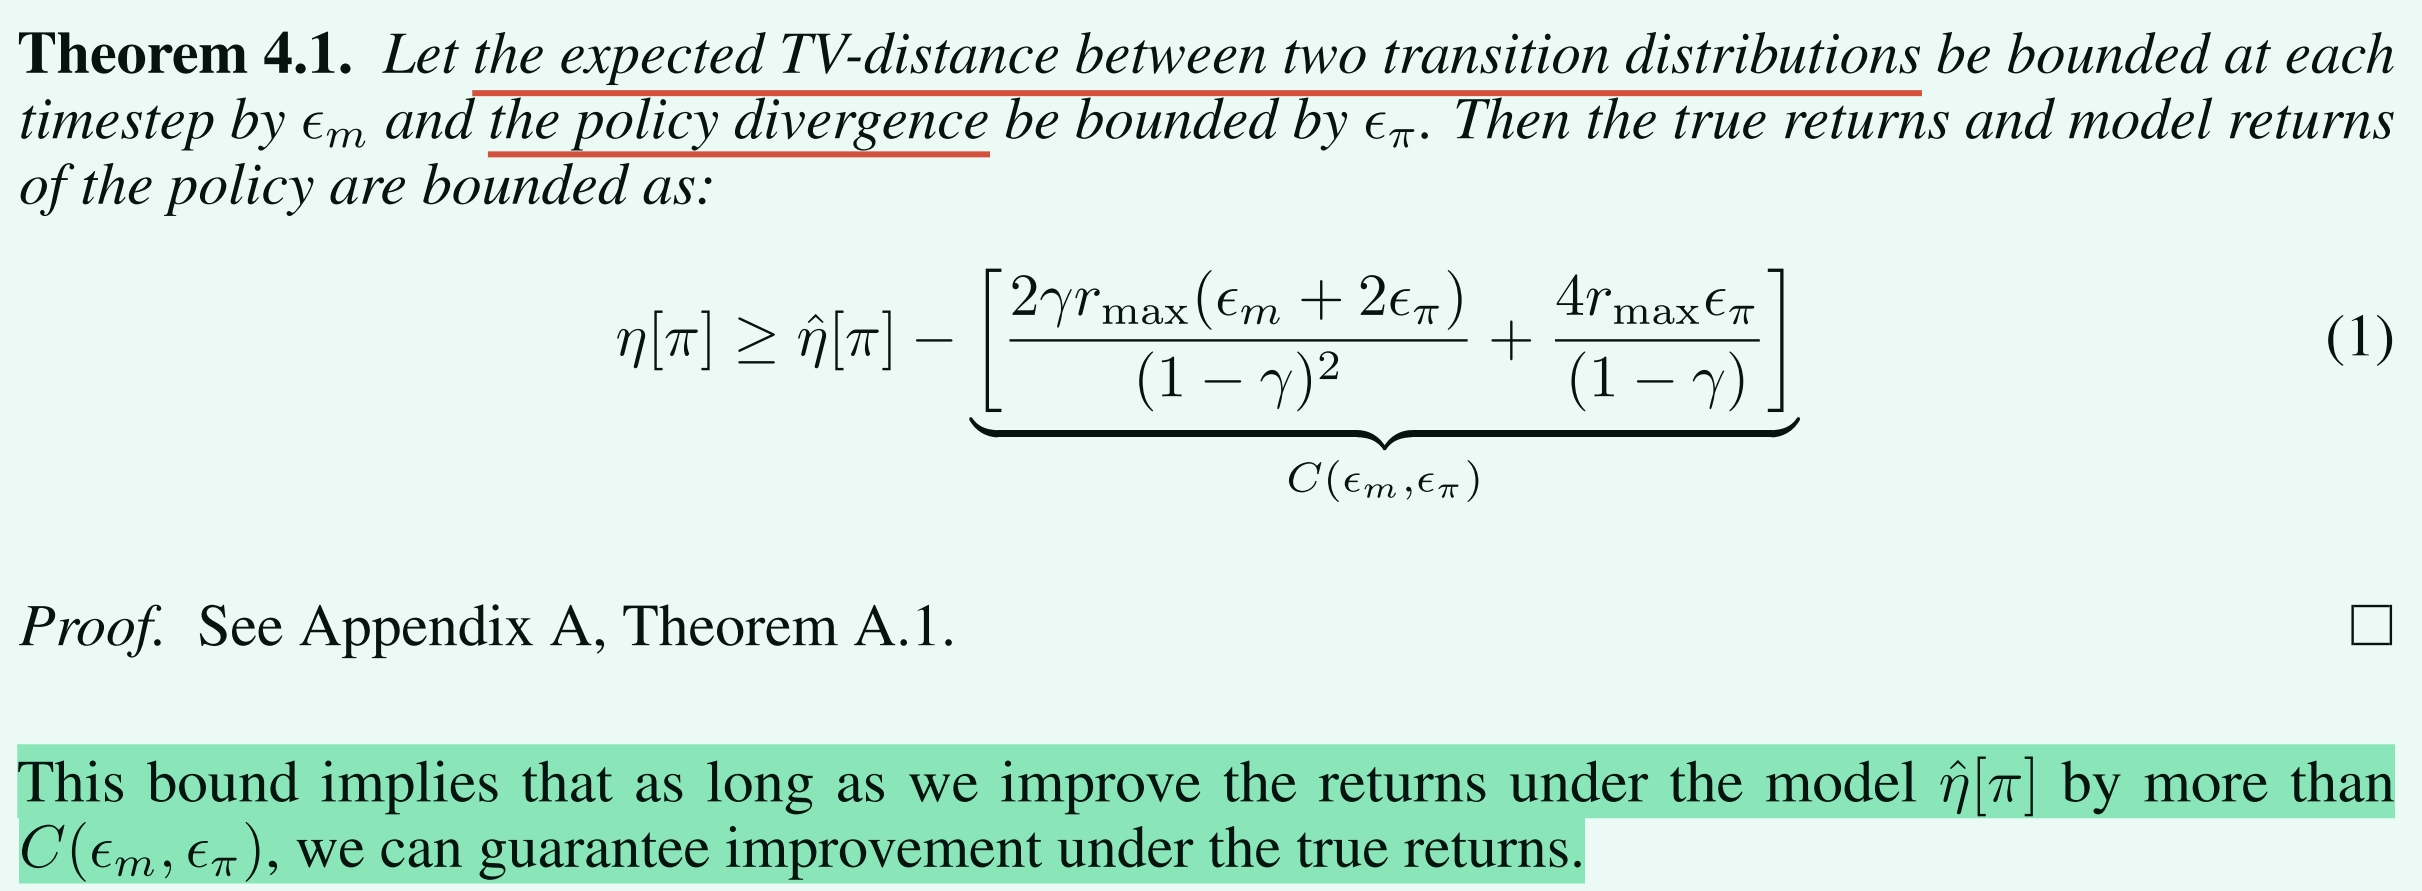

## Interpolating model-based and model-free updates

定理 4.1 将模型回报和真实回报联系起来, 模型误差 ${\epsilon}_m$ (泛化误差)较高时, 导致几个问题:
1. 可能不存在一个policy使得$\hat{\eta}[\pi]-\eta[\pi]>C\left(\epsilon_{m}, \epsilon_{\pi}\right)$, 即无法保证策略性能单调提升.
2. 分析(analysis)依赖于在模型上进行完整推演, 会产生复合误差.

This is reﬂected in the bound by a factor scaling quadratically with the effective horizon, $1 / (1 - \gamma)$.

这反映在与有效视界成二次比例的因子的边界上(?)

在这种情况下，我们可以通过选择减少对模型的依赖，在模型不准确时更多地依赖从真实动力学收集的真实数据来改进算法.

基于在model-based和model-free之间动态调整的需求, 本文提出了**分支推演**(branched rollout)方法, 即从先前策略的状态分布$d_{\pi_{D}}(s)$的一个状态开始, 根据$\pi$在已学习的模型$p_\theta$下推演$k$步.

我们可以将其看作为执行一个非平稳策略, 它通过从先前策略${\pi}_D$中采样动作来开始一次推演. 然后, 在一些特定时刻, 我们切换到模型$p$和当前策略$\pi$推演$k$步.

bound更新为:

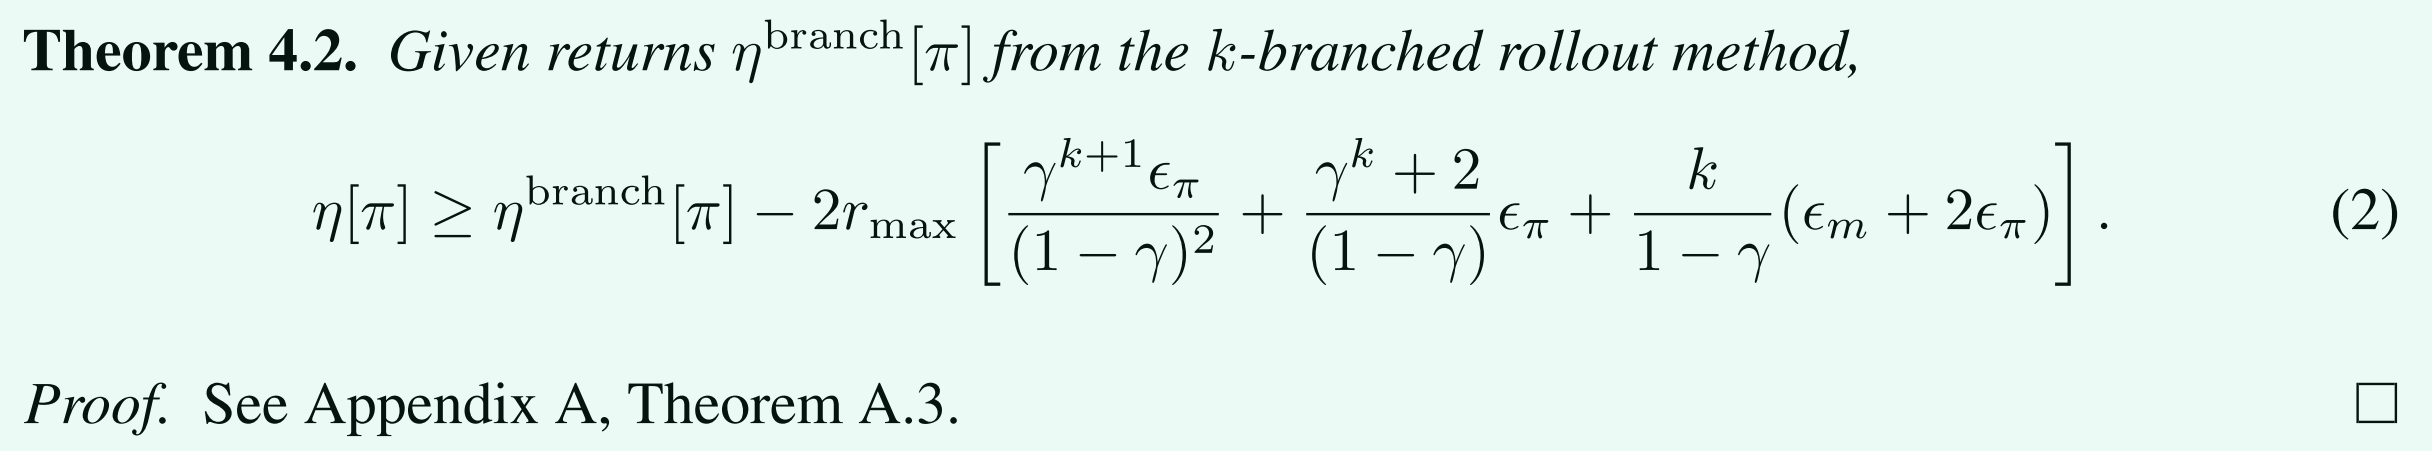

## Model generalization in practice

在定理 4.2 中, 如果我们能够确定模型最优推演长度$k$, 这对算法设计十分有帮助.

公式(2)中 bound由两个相互竞争的因素组成, 一个($\epsilon_{\pi}$)在k中指数下降, 另一个($\epsilon_m$)与k线性缩放. the values of the associated
constants prevent an actual trade-off. 当$k = 0$时, 下界的值最大, 对应着完全不使用模型.

One limitation of the analysis is *pessimistic scaling* of model error $\epsilon_{\pi}$ with respect to policy shift $\epsilon_{m}$, as we do not make any assumptions about the generalization capacity or smoothness properties of the model (Asadi et al., 2018).

为了探究model在实际中的泛化能力如何定量, 本文进行实证测量: model error $\epsilon_{m^\prime}$ 如何随着 policy change $\epsilon_{\pi}$ 而增长. 我们在一个数据收集策略$\pi_D$的状态分布上训练一个模型, 然后在优化策略时测量所有中间策略$\pi$上的模型损失.


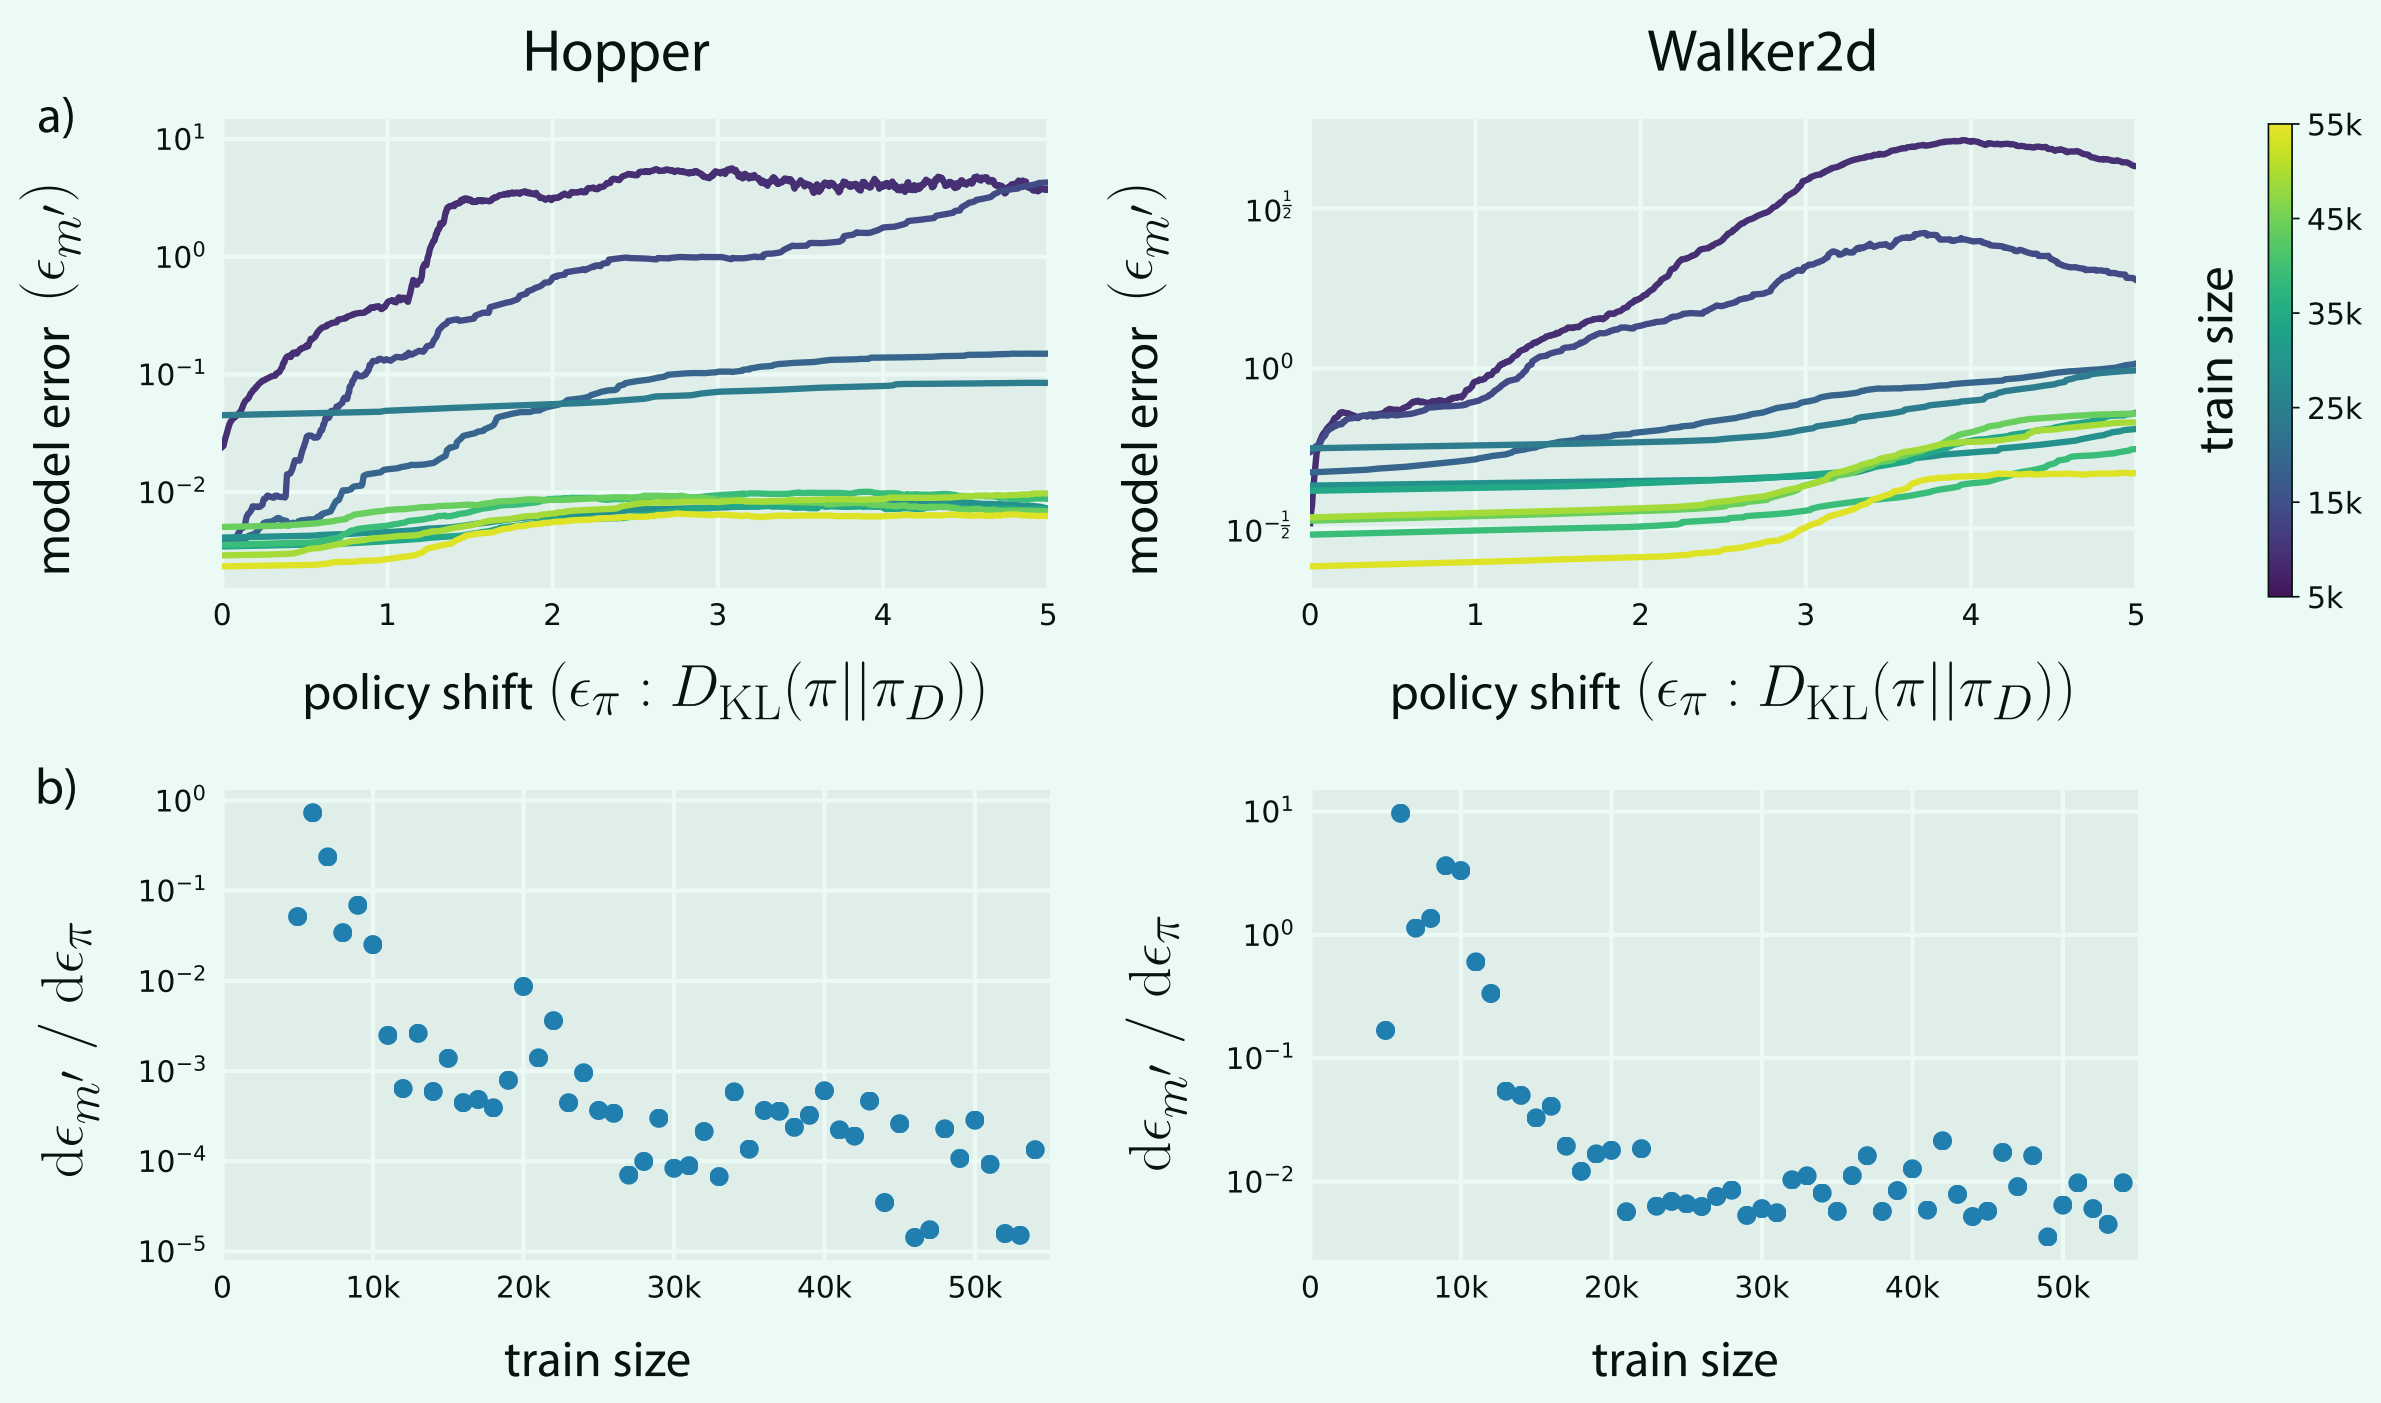

(注): 这里假设了 $\epsilon_m^\prime = \epsilon_{m}+2\epsilon_{\pi}$

Fig.1 (a)
1. model error 随着 current policy $\pi$ 和 data-collecting policy $\pi_D$ 的散度增加. 且增长率由 $\pi_D$ 收集的数据量决定.

Fig.1 (b)
1. 对策略偏移的依赖性降低表明: 使用更多数据训练的模型不仅在其训练分布上表现得更好，而且它们对邻近分布的推广也更好。 

如果我们使用当前策略$\pi$ (代替数据收集策略$\pi_D$) 的分布来近似模型误差$\epsilon_m$, 记为${\epsilon_m}^\prime$. 例如, 用 policy divergence 的线性函数近似${\epsilon_m}^\prime$
$$
\hat{\epsilon}_{m^{\prime}}\left(\epsilon_{\pi}\right) \approx \epsilon_{m}+\epsilon_{\pi} \frac{\mathrm{d} \epsilon_{m^{\prime}}}{\mathrm{d} \epsilon_{\pi}}
$$

bound 再次更新为:

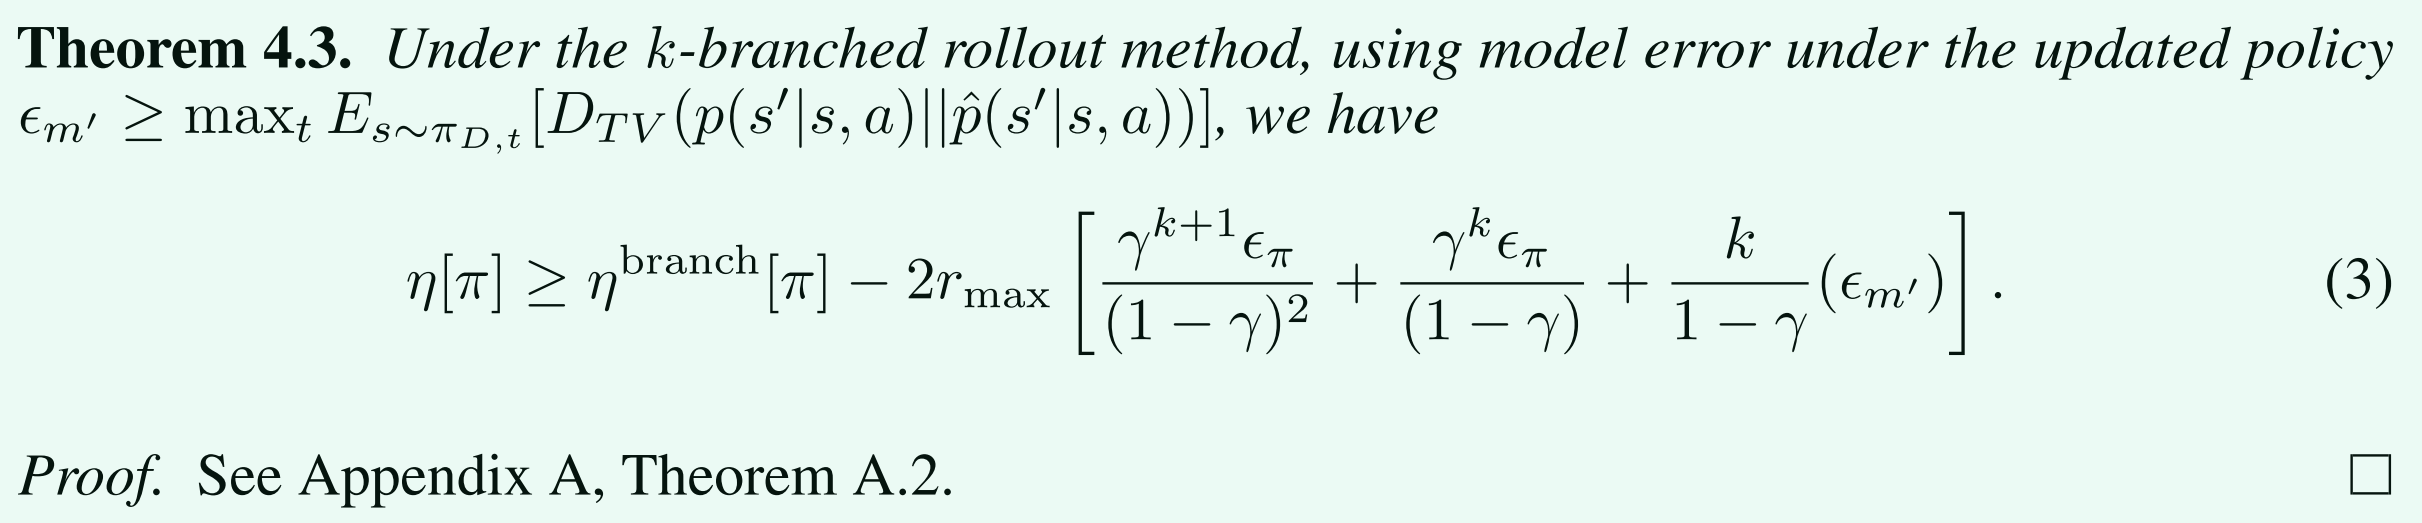

this bound 与定理 4.2 最大的不同在于它激励了模型的使用. 具体而言, 当 $\epsilon_m^\prime$ 足够小时,
$$
k^{*}=\underset{k}{\operatorname{argmin}}\left[\frac{\gamma^{k+1} \epsilon_{\pi}}{(1-\gamma)^{2}}+\frac{\gamma^{k} \epsilon_{\pi}}{(1-\gamma)}+\frac{k}{1-\gamma}\left(\epsilon_{m^{\prime}}\right)\right]>0
$$
即模型误差足够小时, 推演步长大于零, 此时我们就可以使用分支推演预测.

对MBPO算法的实际设计中, 主要使用三个 design decisions:
1. Predictive model. 与PETS一致, Individual probabilistic models capture aleatoric uncertainty. The bootstrapping procedure accounts for epistemic uncertainty.
2. Policy optimization. 使用SAC算法
3. Model usage. 

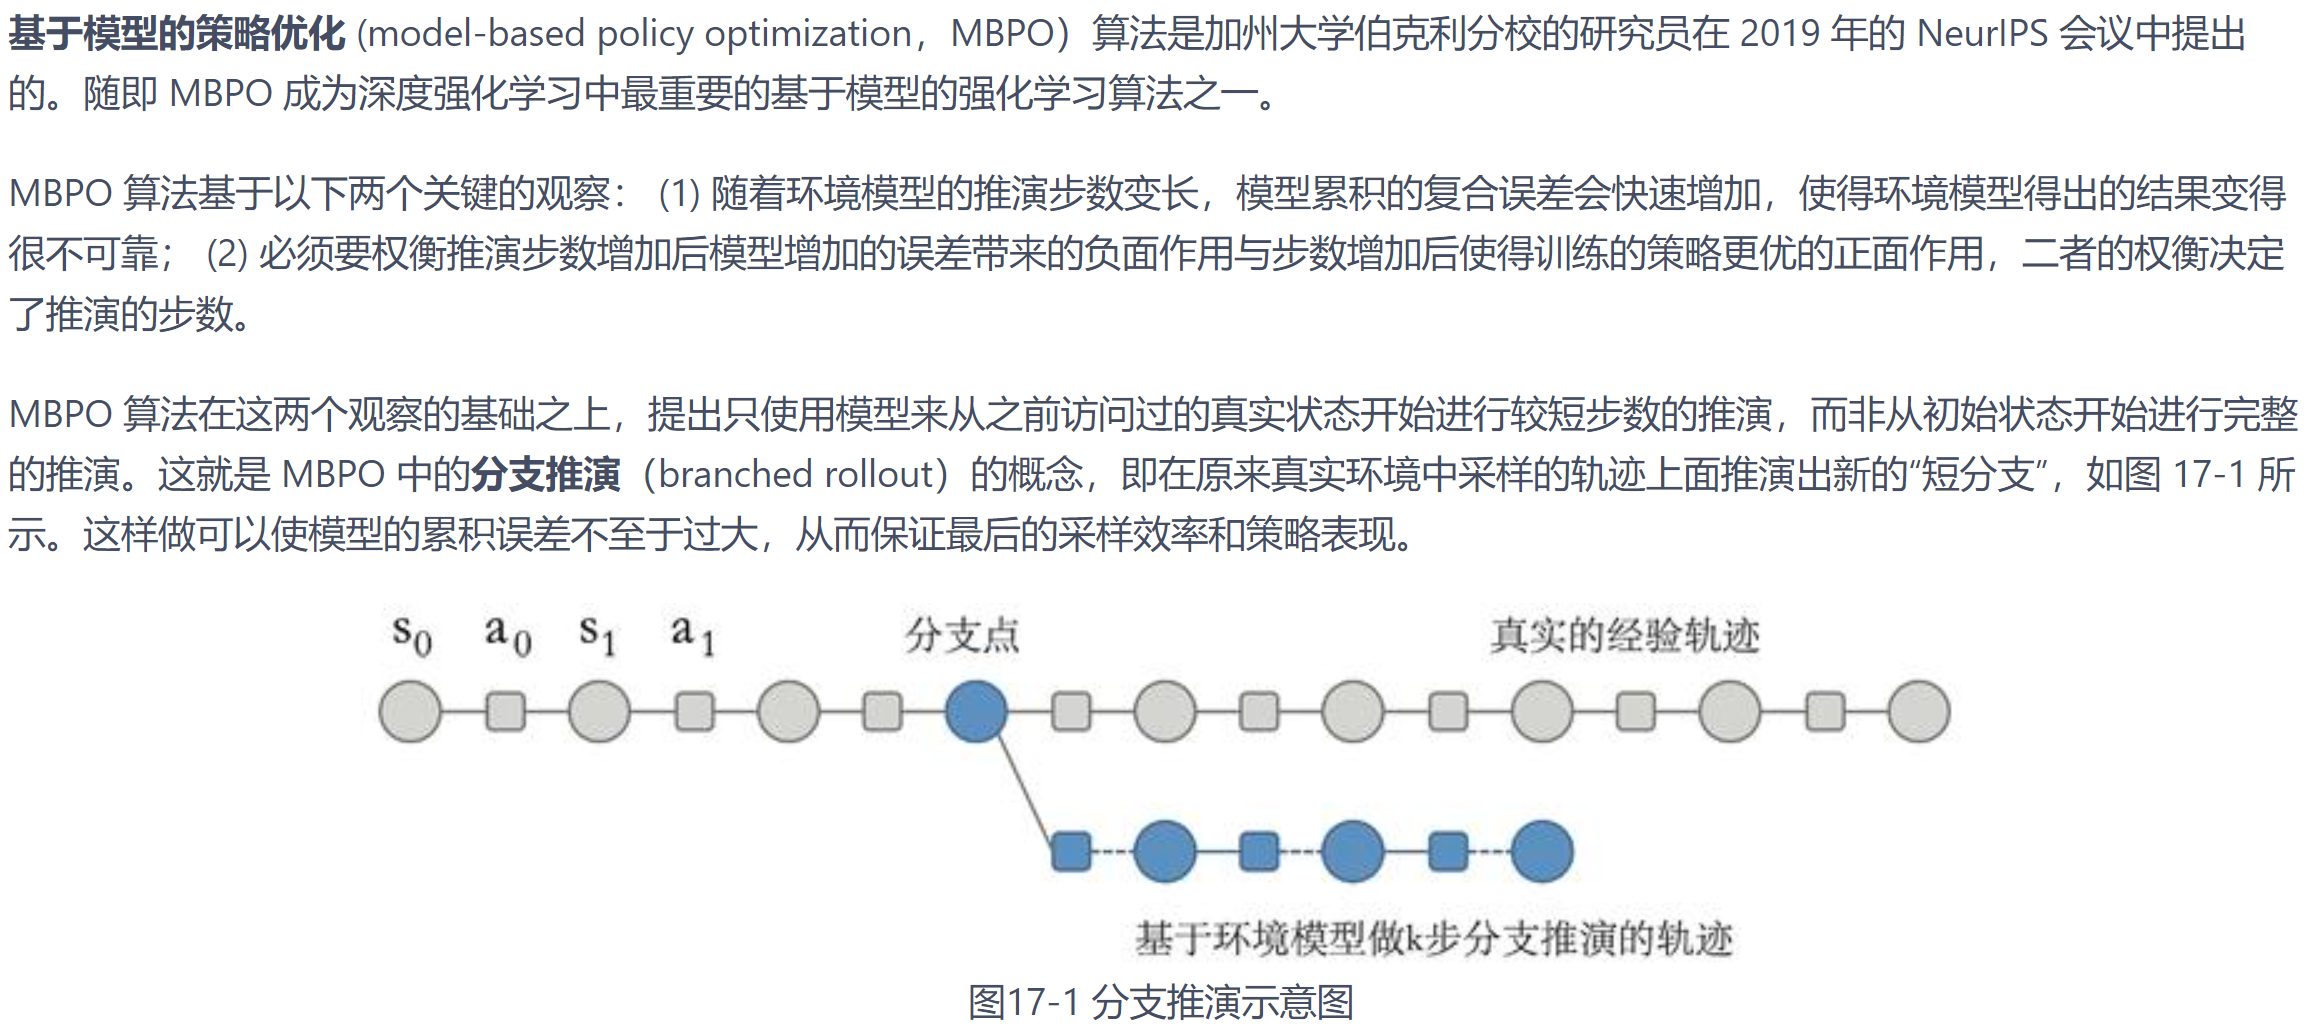

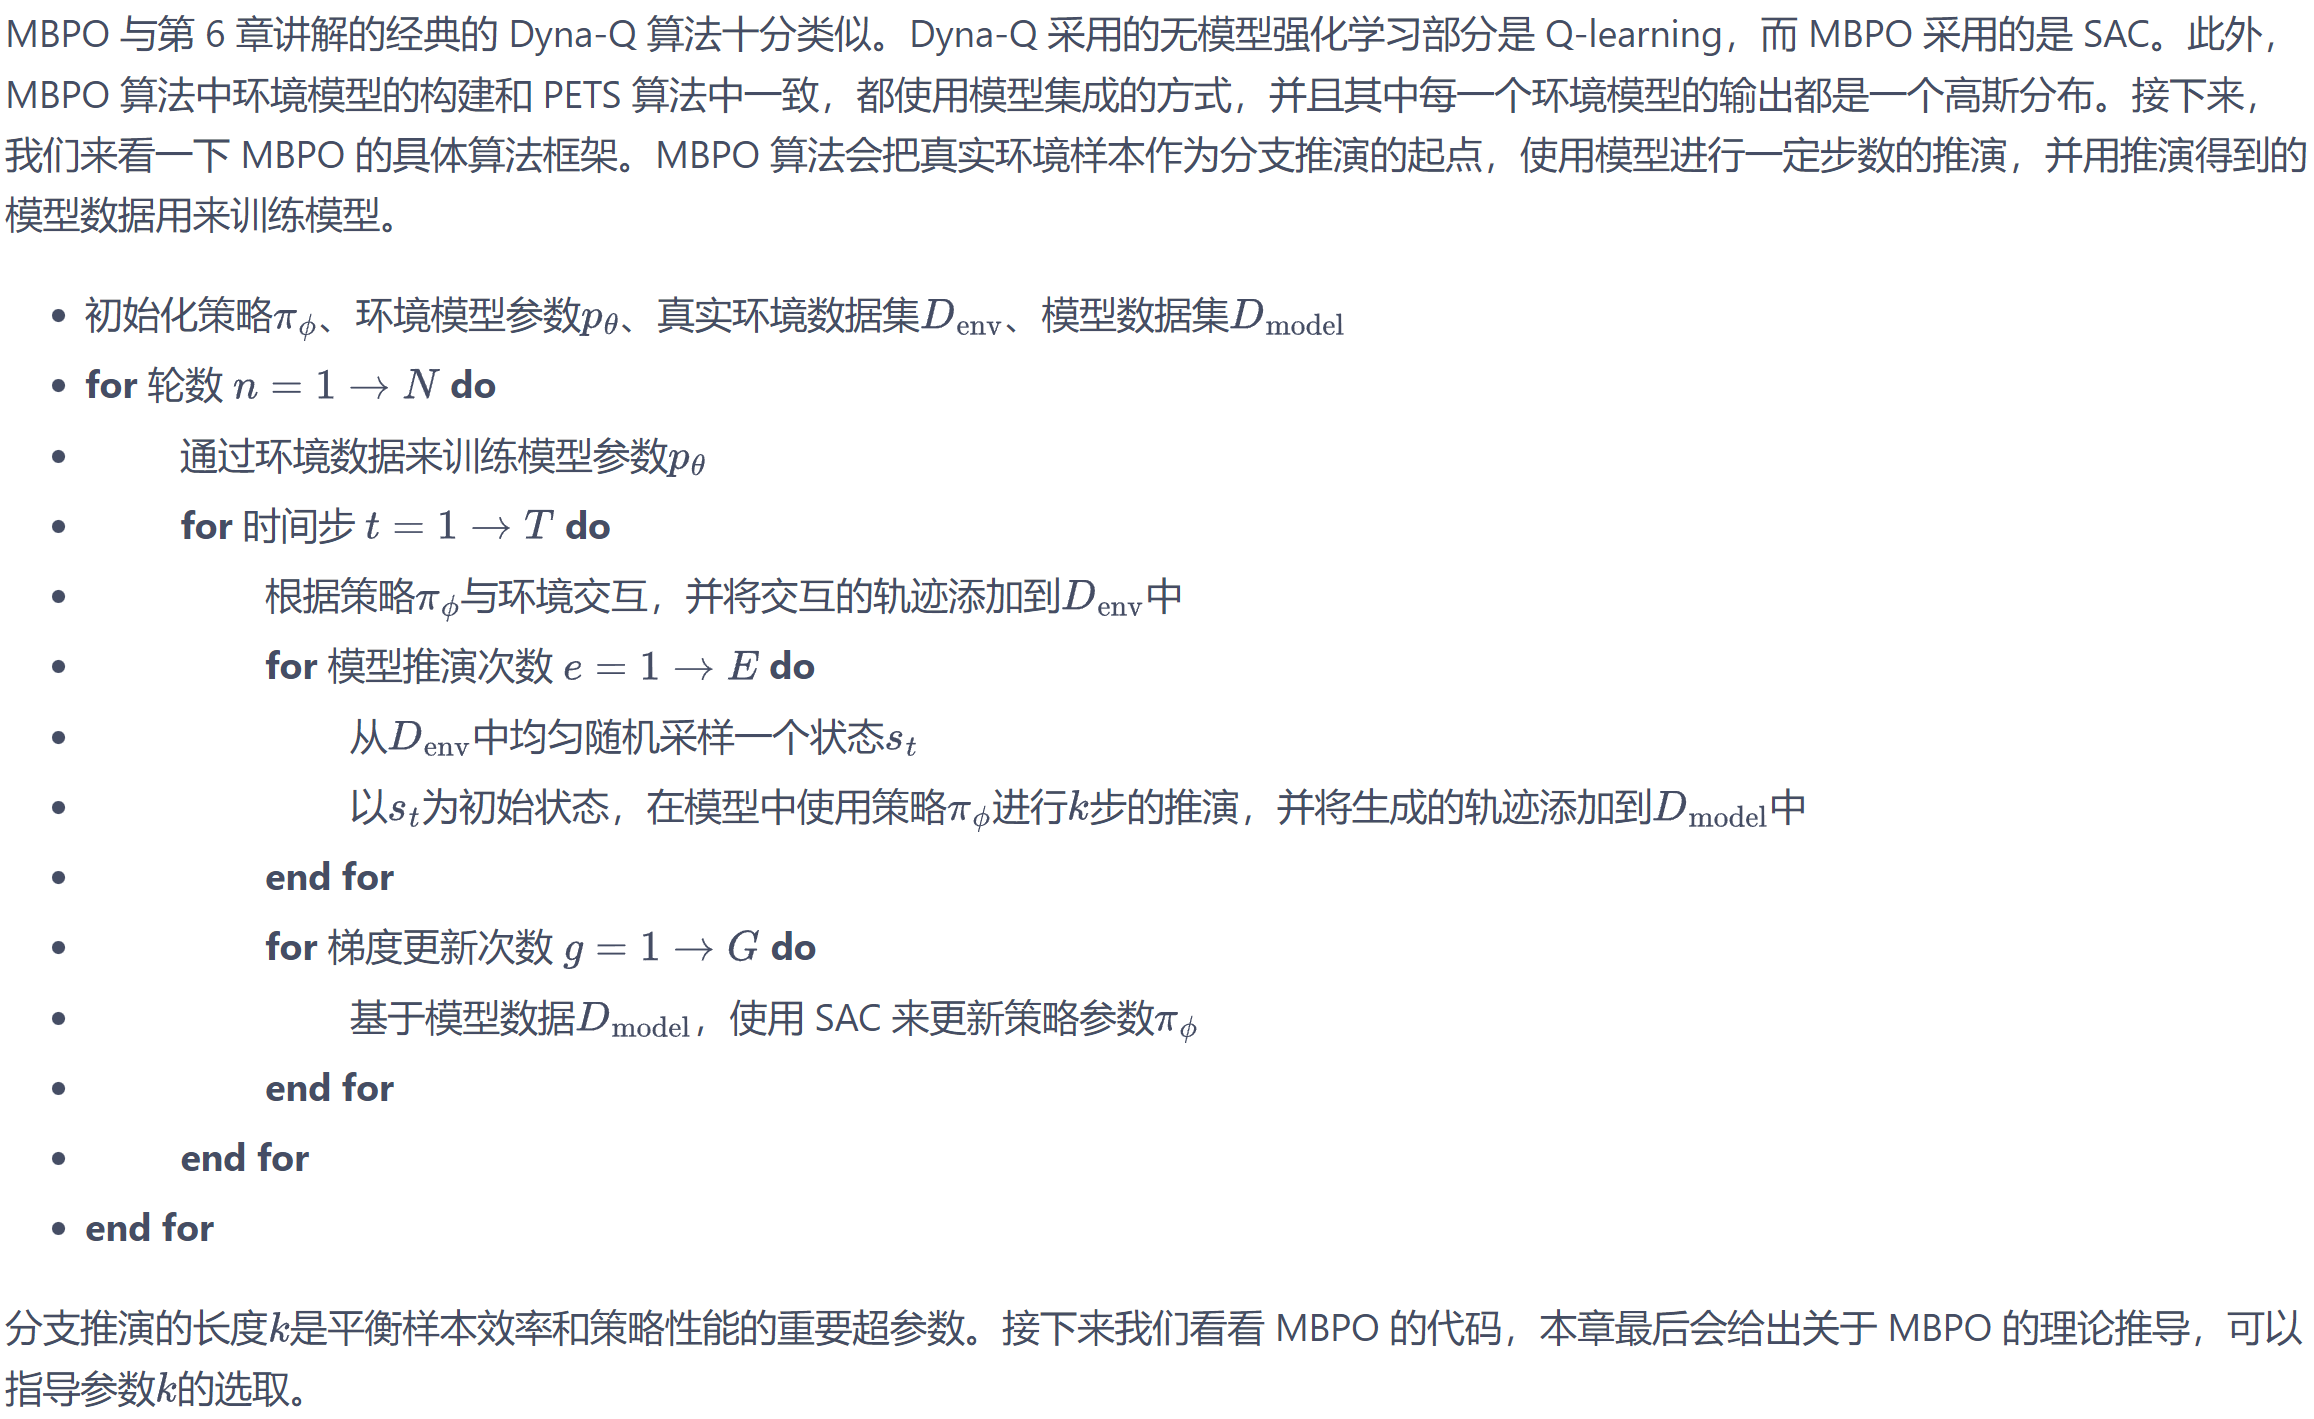

## 讨论

MBPO 算法是一种前沿的基于模型的强化学习算法，它提出了一个重要的概念——分支推演。在各种复杂的环境中，作者验证了 MBPO 的效果超过了之前基于模型的方法。MBPO 对于基于模型的强化学习的发展起着重要的作用，不少之后的工作都是在此基础上进行的。

除了算法的有效性，MBPO 的重要贡献还包括它给出了关于分支推演步数与模型误差、策略偏移程度之间的定量关系，进而阐明了什么时候我们可以相信并使用环境模型，什么样的环境导出的最优分支推演步数为 0，进而建议不使用环境模型。


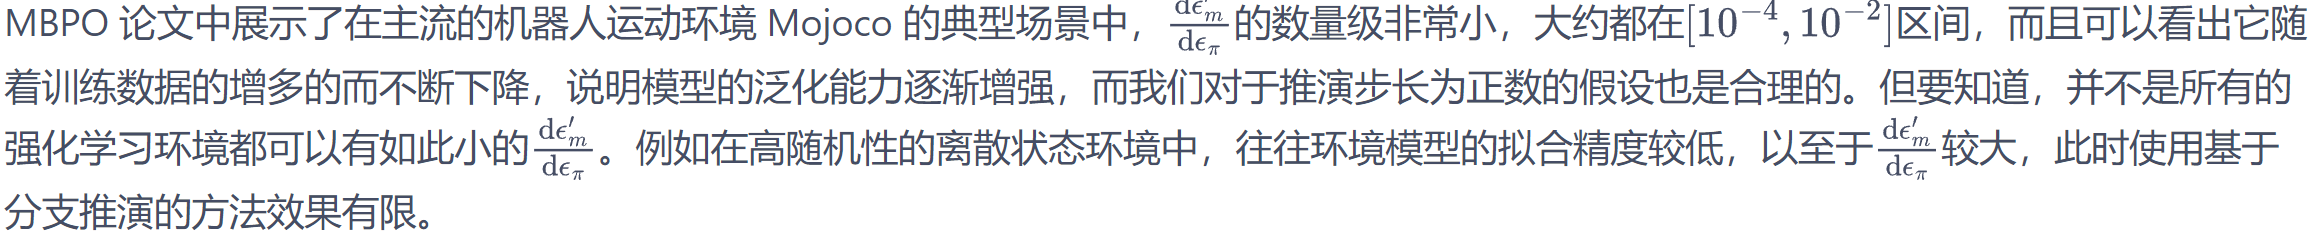